In [13]:
import numpy as np
from collections import Counter
import random
import sys
import chardet

np.random.seed(12345)

print("Importing dataset from disk...")

def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        raw_data = f.read()
        result = chardet.detect(raw_data)
        return result['encoding']

# Detect encoding for spam.txt
encoding_spam = detect_encoding('spam.txt')
with open('spam.txt', 'r', encoding=encoding_spam, errors='replace') as f:
    raw = f.readlines()

spam = [row[:-2].split(" ") for row in raw]

# Detect encoding for ham.txt
encoding_ham = detect_encoding('ham.txt')
with open('ham.txt', 'r', encoding=encoding_ham, errors='replace') as f:
    raw = f.readlines()

ham = [row[:-2].split(" ") for row in raw]

class SVM:
    
    def __init__(self, positives, negatives, iterations=10, alpha=0.005, regularization_strength=0.05):
        self.alpha = alpha
        self.regularization_strength = regularization_strength
        
        # Create vocabulary
        cnts = Counter()
        for email in (positives + negatives):
            for word in email:
                cnts[word] += 1
        
        vocab = list(cnts.keys())
        self.word2index = {word: i for i, word in enumerate(vocab)}
    
        # Initialize weights
        self.weights = (np.random.rand(len(vocab)) - 0.5) * 0.1
        self.bias = 0
        
        # Calculate class weights
        self.class_weight_spam = len(positives + negatives) / (2.0 * len(positives))  # For spam (positive class)
        self.class_weight_ham = len(positives + negatives) / (2.0 * len(negatives))  # For ham (negative class)
        
        # Train model
        self.train(positives, negatives, iterations=iterations)
    
    def train(self, positives, negatives, iterations=10):
        for iter in range(iterations):
            error = 0
            n = 0
            for i in range(max(len(positives), len(negatives))):
                # Train on positive and negative examples
                error += self.learn(positives[i % len(positives)], 1, self.class_weight_spam)
                error += self.learn(negatives[i % len(negatives)], -1, self.class_weight_ham)
                n += 2

            print(f"Iter: {iter} Avg Hinge Loss: {error / float(n)}")
    
    def predict(self, email):
        pred = self.unencrypted_predict(email)
        return np.sign(pred)
    
    def unencrypted_predict(self, email):
        pred = 0
        for word in email:
            if word in self.word2index:
                pred += self.weights[self.word2index[word]]
        pred += self.bias
        return pred

    def learn(self, email, target, class_weight):
        """
        Learn from one example using hinge loss with class weighting.
        """
        pred = self.unencrypted_predict(email)
        if target * pred < 1:  # Misclassified or within margin
            # Update weights and bias
            for word in email:
                if word in self.word2index:
                    self.weights[self.word2index[word]] += self.alpha * class_weight * (target - self.regularization_strength * self.weights[self.word2index[word]])
            self.bias += self.alpha * class_weight * target
            return class_weight * max(0, 1 - target * pred)  # Apply class weight to hinge loss
        else:
            # Regularization update (when the example is correctly classified)
            for word in email:
                if word in self.word2index:
                    self.weights[self.word2index[word]] -= self.alpha * self.regularization_strength * self.weights[self.word2index[word]]
            return 0

# Train the SVM model using class-weighted learning
model = SVM(spam[0:-1000], ham[0:-1000], iterations=50, alpha=0.008, regularization_strength=0.1)

# Evaluate the model
fp = 0
tn = 0
tp = 0
fn = 0

for i, h in enumerate(ham[-1000:]):
    pred = model.predict(h)
    if pred < 0:  # Negative class, so ham
        tn += 1
    else:  # False positive, classified as spam
        fp += 1

    if i % 10 == 0:
        sys.stdout.write('\r I:' + str(tn + tp + fn + fp) + " % Correct:" + str(100 * tn / float(tn + fp))[0:6])

for i, h in enumerate(spam[-1000:]):
    pred = model.predict(h)
    if pred > 0:  # Positive class, so spam
        tp += 1
    else:  # False negative, classified as ham
        fn += 1

    if i % 10 == 0:
        sys.stdout.write('\r I:' + str(tn + tp + fn + fp) + " % Correct:" + str(100 * (tn + tp) / float(tn + tp + fn + fp))[0:6])

sys.stdout.write('\r I:' + str(tn + tp + fn + fp) + " % Correct:" + str(100 * (tn + tp) / float(tn + tp + fn + fp))[0:6])

print("\nAccuracy: %" + str(100 * (tn + tp) / float(tn + tp + fn + fp))[0:6])
print("False Positives: %" + str(100 * fp / float(tp + fp))[0:4] + "    <- privacy violation level")
print("False Negatives: %" + str(100 * fn / float(tn + fn))[0:4] + "   <- security risk level")


Importing dataset from disk...
Iter: 0 Avg Hinge Loss: 0.3479097259987188
Iter: 1 Avg Hinge Loss: 0.12691136246267476
Iter: 2 Avg Hinge Loss: 0.19241222364332944
Iter: 3 Avg Hinge Loss: 0.06246362373513119
Iter: 4 Avg Hinge Loss: 0.19246261714101956
Iter: 5 Avg Hinge Loss: 0.11835125270856997
Iter: 6 Avg Hinge Loss: 0.06225003776756309
Iter: 7 Avg Hinge Loss: 0.20192517295962317
Iter: 8 Avg Hinge Loss: 0.07811829100448543
Iter: 9 Avg Hinge Loss: 0.05050357864976421
Iter: 10 Avg Hinge Loss: 0.21081160252246084
Iter: 11 Avg Hinge Loss: 0.11562362719178465
Iter: 12 Avg Hinge Loss: 0.08927616203611047
Iter: 13 Avg Hinge Loss: 0.11158828003645546
Iter: 14 Avg Hinge Loss: 0.09564059025254384
Iter: 15 Avg Hinge Loss: 0.09245413117220073
Iter: 16 Avg Hinge Loss: 0.11069605182331393
Iter: 17 Avg Hinge Loss: 0.07642610747409352
Iter: 18 Avg Hinge Loss: 0.06494183014203712
Iter: 19 Avg Hinge Loss: 0.0882819096484429
Iter: 20 Avg Hinge Loss: 0.06319971491670619
Iter: 21 Avg Hinge Loss: 0.069029559

In [14]:
import numpy as np
from collections import Counter
import random
import sys
import chardet

np.random.seed(12345)

print("Importing dataset from disk...")

def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        raw_data = f.read()
        result = chardet.detect(raw_data)
        return result['encoding']

# Detect encoding for spam.txt
encoding_spam = detect_encoding('spam.txt')
with open('spam.txt', 'r', encoding=encoding_spam, errors='replace') as f:
    raw = f.readlines()

spam = [row[:-2].split(" ") for row in raw]

# Detect encoding for ham.txt
encoding_ham = detect_encoding('ham.txt')
with open('ham.txt', 'r', encoding=encoding_ham, errors='replace') as f:
    raw = f.readlines()

ham = [row[:-2].split(" ") for row in raw]

class SVM:
    
    def __init__(self, positives, negatives, iterations=10, alpha=0.005, regularization_strength=0.05):
        self.alpha = alpha
        self.regularization_strength = regularization_strength
        
        # Create vocabulary
        cnts = Counter()
        for email in (positives + negatives):
            for word in email:
                cnts[word] += 1
        
        vocab = list(cnts.keys())
        self.word2index = {word: i for i, word in enumerate(vocab)}
    
        # Initialize weights
        self.weights = (np.random.rand(len(vocab)) - 0.5) * 0.1
        self.bias = 0
        
        # Calculate class weights
        self.class_weight_spam = len(positives + negatives) / (2.0 * len(positives))  # For spam (positive class)
        self.class_weight_ham = len(positives + negatives) / (2.0 * len(negatives))  # For ham (negative class)
        
        # Train model
        self.train(positives, negatives, iterations=iterations)
    
    def train(self, positives, negatives, iterations=10):
        for iter in range(iterations):
            error = 0
            n = 0
            for i in range(max(len(positives), len(negatives))):
                # Train on positive and negative examples
                error += self.learn(positives[i % len(positives)], 1, self.class_weight_spam)
                error += self.learn(negatives[i % len(negatives)], -1, self.class_weight_ham)
                n += 2

            print(f"Iter: {iter} Avg Hinge Loss: {error / float(n)}")
    
    def predict(self, email):
        pred = self.unencrypted_predict(email)
        return np.sign(pred)
    
    def unencrypted_predict(self, email):
        pred = 0
        for word in email:
            if word in self.word2index:
                pred += self.weights[self.word2index[word]]
        pred += self.bias
        return pred

    def learn(self, email, target, class_weight):
        """
        Learn from one example using hinge loss with class weighting.
        """
        pred = self.unencrypted_predict(email)
        if target * pred < 1:  # Misclassified or within margin
            # Update weights and bias
            for word in email:
                if word in self.word2index:
                    self.weights[self.word2index[word]] += self.alpha * class_weight * (target - self.regularization_strength * self.weights[self.word2index[word]])
            self.bias += self.alpha * class_weight * target
            return class_weight * max(0, 1 - target * pred)  # Apply class weight to hinge loss
        else:
            # Regularization update (when the example is correctly classified)
            for word in email:
                if word in self.word2index:
                    self.weights[self.word2index[word]] -= self.alpha * self.regularization_strength * self.weights[self.word2index[word]]
            return 0

# Train the SVM model using class-weighted learning
model = SVM(spam[0:-1000], ham[0:-1000], iterations=50, alpha=0.005, regularization_strength=0.15)

# Evaluate the model
fp = 0
tn = 0
tp = 0
fn = 0

for i, h in enumerate(ham[-1000:]):
    pred = model.predict(h)
    if pred < 0:  # Negative class, so ham
        tn += 1
    else:  # False positive, classified as spam
        fp += 1

    if i % 10 == 0:
        sys.stdout.write('\r I:' + str(tn + tp + fn + fp) + " % Correct:" + str(100 * tn / float(tn + fp))[0:6])

for i, h in enumerate(spam[-1000:]):
    pred = model.predict(h)
    if pred > 0:  # Positive class, so spam
        tp += 1
    else:  # False negative, classified as ham
        fn += 1

    if i % 10 == 0:
        sys.stdout.write('\r I:' + str(tn + tp + fn + fp) + " % Correct:" + str(100 * (tn + tp) / float(tn + tp + fn + fp))[0:6])

sys.stdout.write('\r I:' + str(tn + tp + fn + fp) + " % Correct:" + str(100 * (tn + tp) / float(tn + tp + fn + fp))[0:6])

print("\nAccuracy: %" + str(100 * (tn + tp) / float(tn + tp + fn + fp))[0:6])
print("False Positives: %" + str(100 * fp / float(tp + fp))[0:4] + "    <- privacy violation level")
print("False Negatives: %" + str(100 * fn / float(tn + fn))[0:4] + "   <- security risk level")


Importing dataset from disk...
Iter: 0 Avg Hinge Loss: 0.29077879472627793
Iter: 1 Avg Hinge Loss: 0.09454807004125755
Iter: 2 Avg Hinge Loss: 0.12995744746318927
Iter: 3 Avg Hinge Loss: 0.0977860489877116
Iter: 4 Avg Hinge Loss: 0.07241684504606379
Iter: 5 Avg Hinge Loss: 0.0846983369206138
Iter: 6 Avg Hinge Loss: 0.05854650476911265
Iter: 7 Avg Hinge Loss: 0.07045641092528987
Iter: 8 Avg Hinge Loss: 0.05221536481273749
Iter: 9 Avg Hinge Loss: 0.05662334796952123
Iter: 10 Avg Hinge Loss: 0.08114024841094307
Iter: 11 Avg Hinge Loss: 0.07633703904837863
Iter: 12 Avg Hinge Loss: 0.13610273456558522
Iter: 13 Avg Hinge Loss: 0.0750766280094622
Iter: 14 Avg Hinge Loss: 0.06099816194294786
Iter: 15 Avg Hinge Loss: 0.043882465337187204
Iter: 16 Avg Hinge Loss: 0.07622035380367476
Iter: 17 Avg Hinge Loss: 0.05819049872486148
Iter: 18 Avg Hinge Loss: 0.04510003060558581
Iter: 19 Avg Hinge Loss: 0.06795549309800365
Iter: 20 Avg Hinge Loss: 0.08861657317238193
Iter: 21 Avg Hinge Loss: 0.041051498

In [15]:
import numpy as np
from collections import Counter
import random
import sys
import chardet

np.random.seed(12345)

print("Importing dataset from disk...")

def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        raw_data = f.read()
        result = chardet.detect(raw_data)
        return result['encoding']

# Detect encoding for spam.txt
encoding_spam = detect_encoding('spam.txt')
with open('spam.txt', 'r', encoding=encoding_spam, errors='replace') as f:
    raw = f.readlines()

spam = [row[:-2].split(" ") for row in raw]

# Detect encoding for ham.txt
encoding_ham = detect_encoding('ham.txt')
with open('ham.txt', 'r', encoding=encoding_ham, errors='replace') as f:
    raw = f.readlines()

ham = [row[:-2].split(" ") for row in raw]

class SVM:
    
    def __init__(self, positives, negatives, iterations=10, alpha=0.005, regularization_strength=0.05):
        self.alpha = alpha
        self.regularization_strength = regularization_strength
        
        # Create vocabulary
        cnts = Counter()
        for email in (positives + negatives):
            for word in email:
                cnts[word] += 1
        
        vocab = list(cnts.keys())
        self.word2index = {word: i for i, word in enumerate(vocab)}
    
        # Initialize weights
        self.weights = (np.random.rand(len(vocab)) - 0.5) * 0.1
        self.bias = 0
        
        # Calculate class weights
        self.class_weight_spam = len(positives + negatives) / (2.0 * len(positives))  # For spam (positive class)
        self.class_weight_ham = len(positives + negatives) / (2.0 * len(negatives))  # For ham (negative class)
        
        # Train model
        self.train(positives, negatives, iterations=iterations)
    
    def train(self, positives, negatives, iterations=10):
        for iter in range(iterations):
            error = 0
            n = 0
            for i in range(max(len(positives), len(negatives))):
                # Train on positive and negative examples
                error += self.learn(positives[i % len(positives)], 1, self.class_weight_spam)
                error += self.learn(negatives[i % len(negatives)], -1, self.class_weight_ham)
                n += 2

            print(f"Iter: {iter} Avg Hinge Loss: {error / float(n)}")
    
    def predict(self, email):
        pred = self.unencrypted_predict(email)
        return np.sign(pred)
    
    def unencrypted_predict(self, email):
        pred = 0
        for word in email:
            if word in self.word2index:
                pred += self.weights[self.word2index[word]]
        pred += self.bias
        return pred

    def learn(self, email, target, class_weight):
        """
        Learn from one example using hinge loss with class weighting.
        """
        pred = self.unencrypted_predict(email)
        if target * pred < 1:  # Misclassified or within margin
            # Update weights and bias
            for word in email:
                if word in self.word2index:
                    self.weights[self.word2index[word]] += self.alpha * class_weight * (target - self.regularization_strength * self.weights[self.word2index[word]])
            self.bias += self.alpha * class_weight * target
            return class_weight * max(0, 1 - target * pred)  # Apply class weight to hinge loss
        else:
            # Regularization update (when the example is correctly classified)
            for word in email:
                if word in self.word2index:
                    self.weights[self.word2index[word]] -= self.alpha * self.regularization_strength * self.weights[self.word2index[word]]
            return 0

# Train the SVM model using class-weighted learning
model = SVM(spam[0:-1000], ham[0:-1000], iterations=50, alpha=0.002, regularization_strength=0.15)

# Evaluate the model
fp = 0
tn = 0
tp = 0
fn = 0

for i, h in enumerate(ham[-1000:]):
    pred = model.predict(h)
    if pred < 0:  # Negative class, so ham
        tn += 1
    else:  # False positive, classified as spam
        fp += 1

    if i % 10 == 0:
        sys.stdout.write('\r I:' + str(tn + tp + fn + fp) + " % Correct:" + str(100 * tn / float(tn + fp))[0:6])

for i, h in enumerate(spam[-1000:]):
    pred = model.predict(h)
    if pred > 0:  # Positive class, so spam
        tp += 1
    else:  # False negative, classified as ham
        fn += 1

    if i % 10 == 0:
        sys.stdout.write('\r I:' + str(tn + tp + fn + fp) + " % Correct:" + str(100 * (tn + tp) / float(tn + tp + fn + fp))[0:6])

sys.stdout.write('\r I:' + str(tn + tp + fn + fp) + " % Correct:" + str(100 * (tn + tp) / float(tn + tp + fn + fp))[0:6])

print("\nAccuracy: %" + str(100 * (tn + tp) / float(tn + tp + fn + fp))[0:6])
print("False Positives: %" + str(100 * fp / float(tp + fp))[0:4] + "    <- privacy violation level")
print("False Negatives: %" + str(100 * fn / float(tn + fn))[0:4] + "   <- security risk level")


Importing dataset from disk...
Iter: 0 Avg Hinge Loss: 0.1548281635146259
Iter: 1 Avg Hinge Loss: 0.0755481961485878
Iter: 2 Avg Hinge Loss: 0.04436736824616863
Iter: 3 Avg Hinge Loss: 0.0948758072927415
Iter: 4 Avg Hinge Loss: 0.03886713362116495
Iter: 5 Avg Hinge Loss: 0.031178211702105316
Iter: 6 Avg Hinge Loss: 0.03233633997401704
Iter: 7 Avg Hinge Loss: 0.02984675843973002
Iter: 8 Avg Hinge Loss: 0.025423250449728912
Iter: 9 Avg Hinge Loss: 0.028039331237342906
Iter: 10 Avg Hinge Loss: 0.033847160887986026
Iter: 11 Avg Hinge Loss: 0.04172742374806986
Iter: 12 Avg Hinge Loss: 0.021596998052713014
Iter: 13 Avg Hinge Loss: 0.04960531684035482
Iter: 14 Avg Hinge Loss: 0.03365676055525974
Iter: 15 Avg Hinge Loss: 0.022658128821037217
Iter: 16 Avg Hinge Loss: 0.025096127589202738
Iter: 17 Avg Hinge Loss: 0.03522362032440173
Iter: 18 Avg Hinge Loss: 0.02891721378600951
Iter: 19 Avg Hinge Loss: 0.021342859125341795
Iter: 20 Avg Hinge Loss: 0.022508965329422172
Iter: 21 Avg Hinge Loss: 0.0

In [1]:
import numpy as np
from collections import Counter
import chardet
import math
import re
import libnum

np.random.seed(12345)

print("Importing dataset from disk...")

# Function to detect the encoding of the dataset files
def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        raw_data = f.read()
        result = chardet.detect(raw_data)
        return result['encoding']

# Detect encoding for spam.txt and ham.txt
encoding_spam = detect_encoding('spam.txt')
with open('spam.txt', 'r', encoding=encoding_spam, errors='replace') as f:
    raw = f.readlines()
spam = [row[:-2].split(" ") for row in raw]

encoding_ham = detect_encoding('ham.txt')
with open('ham.txt', 'r', encoding=encoding_ham, errors='replace') as f:
    raw = f.readlines()
ham = [row[:-2].split(" ") for row in raw]

def mod_inverse(x, n):
    return pow(x, -1, n)

def L(x, n):
    return (x - 1) // n

def generate_keys(bit_length=256):
    print("Generating keys, please wait...")

    p = libnum.generate_prime(bit_length // 2)
    q = libnum.generate_prime(bit_length // 2)
    n = p * q
    n_sq = n * n
    lambda_param = (p - 1) * (q - 1) // math.gcd(p - 1, q - 1)
    g = n + 1
    mu = mod_inverse(L(pow(g, lambda_param, n_sq), n), n)
    print(f"Keys generated successfully! (bit length: {bit_length})\n")

    public_key = (n, g)
    private_key = (lambda_param, mu)
    return public_key, private_key

class EncryptedNumber:
    def __init__(self, ciphertext):
        self.ciphertext = ciphertext

def encrypt(public_key, plaintext, scaling_factor=10000):
    n, g = public_key
    n_sq = n * n
    r = libnum.randint_bits(n.bit_length() - 1) % n
    ciphertext = (pow(g, int(plaintext * scaling_factor), n_sq) * pow(r, n, n_sq)) % n_sq
    return EncryptedNumber(ciphertext)

def decrypt(private_key, public_key, encrypted_number, scaling_factor=10000):
    n, g = public_key
    lambda_param, mu = private_key
    n_sq = n * n
    ciphertext = encrypted_number.ciphertext
    x = pow(ciphertext, lambda_param, n_sq)
    plaintext = (L(x, n) * mu) % n
    return plaintext / scaling_factor

# Modify the SVM class to use encryption/decryption
class SVM:
    
    def __init__(self, positives, negatives, public_key, iterations=10, alpha=0.005, regularization_strength=0.05, weight_scale=1e5):
        self.alpha = alpha
        self.regularization_strength = regularization_strength
        self.pubkey = public_key
        self.weight_scale = weight_scale
        
        # Create vocabulary
        cnts = Counter()
        for email in (positives + negatives):
            for word in email:
                cnts[word] += 1
        
        vocab = list(cnts.keys())
        self.word2index = {word: i for i, word in enumerate(vocab)}
    
        # Initialize weights
        self.weights = (np.random.rand(len(vocab)) - 0.5) * 0.1
        self.bias = 0
        
        # Encrypt weights after training
        self.encrypted_weights = [encrypt(self.pubkey, weight) for weight in self.weights]

        # Calculate class weights
        self.class_weight_spam = len(positives + negatives) / (2.0 * len(positives))  # For spam (positive class)
        self.class_weight_ham = len(positives + negatives) / (2.0 * len(negatives))  # For ham (negative class)
        
        # Train model
        self.train(positives, negatives, iterations=iterations)
    
    def train(self, positives, negatives, iterations=10):
        for iter in range(iterations):
            error = 0
            n = 0
            for i in range(max(len(positives), len(negatives))):
                # Train on positive and negative examples
                error += self.learn(positives[i % len(positives)], 1, self.class_weight_spam)
                error += self.learn(negatives[i % len(negatives)], -1, self.class_weight_ham)
                n += 2

            print(f"Iter: {iter} Avg Hinge Loss: {error / float(n)}")
    
        # Encrypt weights after training
        self.encrypted_weights = [encrypt(self.pubkey, weight) for weight in self.weights]
        print("Weights encrypted after training.")

    def predict(self, email, encrypt_output=True):
        pred = self.unencrypted_predict(email)
        if encrypt_output:
            encrypted_pred = encrypt(self.pubkey, pred)
            return encrypted_pred
        
        return np.sign(pred)
    
    def unencrypted_predict(self, email):
        pred = 0
        for word in email:
            if word in self.word2index:
                pred += self.weights[self.word2index[word]]
        pred += self.bias
        return pred

    def learn(self, email, target, class_weight):
        """
        Learn from one example using hinge loss with class weighting.
        """
        pred = self.unencrypted_predict(email)
        if target * pred < 1:  # Misclassified or within margin
            # Update weights and bias
            for word in email:
                if word in self.word2index:
                    self.weights[self.word2index[word]] += self.alpha * class_weight * (target - self.regularization_strength * self.weights[self.word2index[word]])
            self.bias += self.alpha * class_weight * target
            return class_weight * max(0, 1 - target * pred)  # Apply class weight to hinge loss
        else:
            # Regularization update (when the example is correctly classified)
            for word in email:
                if word in self.word2index:
                    self.weights[self.word2index[word]] -= self.alpha * self.regularization_strength * self.weights[self.word2index[word]]
            return 0

# Key generation for encryption
public_key, private_key = generate_keys(bit_length=64)

# Train the SVM model using class-weighted learning and encryption
model = SVM(spam[0:-1000], ham[0:-1000], public_key, iterations=50, alpha=0.002, regularization_strength=0.15)

# Evaluate the model
fp = 0
tn = 0
tp = 0
fn = 0

for i, h in enumerate(ham[-1000:]):
    pred = model.predict(h, encrypt_output=False)
    if pred < 0:  # Negative class, so ham
        tn += 1
    else:  # False positive, classified as spam
        fp += 1

    if i % 10 == 0:
        print(f'I: {tn + tp + fn + fp} % Correct: {100 * tn / float(tn + fp):.2f}')

for i, h in enumerate(spam[-1000:]):
    pred = model.predict(h, encrypt_output=False)
    if pred > 0:  # Positive class, so spam
        tp += 1
    else:  # False negative, classified as ham
        fn += 1

print(f'\nAccuracy: {100 * (tn + tp) / float(tn + tp + fn + fp):.2f}%')
print(f'False Positives: {100 * fp / float(tp + fp):.2f}%    <- privacy violation level')
print(f'False Negatives: {100 * fn / float(tn + fn):.2f}%   <- security risk level')


Importing dataset from disk...
Generating keys, please wait...
Keys generated successfully! (bit length: 64)

Iter: 0 Avg Hinge Loss: 0.1548281635146259
Iter: 1 Avg Hinge Loss: 0.0755481961485878
Iter: 2 Avg Hinge Loss: 0.04436736824616863
Iter: 3 Avg Hinge Loss: 0.0948758072927415
Iter: 4 Avg Hinge Loss: 0.03886713362116495
Iter: 5 Avg Hinge Loss: 0.031178211702105316
Iter: 6 Avg Hinge Loss: 0.03233633997401704
Iter: 7 Avg Hinge Loss: 0.02984675843973002
Iter: 8 Avg Hinge Loss: 0.025423250449728912
Iter: 9 Avg Hinge Loss: 0.028039331237342906
Iter: 10 Avg Hinge Loss: 0.033847160887986026
Iter: 11 Avg Hinge Loss: 0.04172742374806986
Iter: 12 Avg Hinge Loss: 0.021596998052713014
Iter: 13 Avg Hinge Loss: 0.04960531684035482
Iter: 14 Avg Hinge Loss: 0.03365676055525974
Iter: 15 Avg Hinge Loss: 0.022658128821037217
Iter: 16 Avg Hinge Loss: 0.025096127589202738
Iter: 17 Avg Hinge Loss: 0.03522362032440173
Iter: 18 Avg Hinge Loss: 0.02891721378600951
Iter: 19 Avg Hinge Loss: 0.02134285912534

In [2]:
model.predict(spam[0])

In [4]:
model.predict(spam[0], encrypt_output=False)

np.float64(1.0)

In [15]:
import libnum
import math
from itertools import product

def L(x, n):
    return (x - 1) // n

def mod_inverse(x, n):
    return pow(x, -1, n)

def brute_force_decrypt(public_key, ciphertext, max_key_size=512):
    n, g = public_key
    n_sq = n * n
    
    # Try different values of p and q up to a certain size
    for p_guess in range(2, 2**max_key_size):
        if n % p_guess == 0:  # Found a divisor of n, hence q
            q_guess = n // p_guess
            if p_guess * q_guess == n:
                # We have found p and q, now calculate lambda and mu
                lambda_param = (p_guess - 1) * (q_guess - 1) // math.gcd(p_guess - 1, q_guess - 1)
                mu = mod_inverse(L(pow(g, lambda_param, n_sq), n), n)
                
                # Try decrypting the ciphertext with the guessed key
                decrypted_value = decrypt((lambda_param, mu), public_key, ciphertext)
                print(f"Decrypted Value with p={p_guess}, q={q_guess}: {decrypted_value}")
                return decrypted_value  # Return after first success
    return None

# Example encryption to test (simulated ciphertext and public_key)
public_key = (123456786543213145675432131456786656453423456786978675654676686, 67686543243568765434567865435678976543567865)  # Small keys for testing
ciphertext = EncryptedNumber(2345678654321456789765432456789765432245678)  # Example ciphertext

# Attempt to brute-force the encryption
decrypted_value = brute_force_decrypt(public_key, ciphertext, max_key_size=512)
if decrypted_value:
    print(f"Success! Decrypted value: {decrypted_value}")
else:
    print("Failed to brute force the encryption.")


Decrypted Value with p=2, q=61728393271606572837716065728393328226711728393489337827338343: 1.0183460104133623e+58
Success! Decrypted value: 1.0183460104133623e+58


In [12]:
import numpy as np
from collections import Counter
import chardet
import math
import libnum

np.random.seed(12345)

# Function to detect encoding of dataset files
def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        raw_data = f.read()
        result = chardet.detect(raw_data)
        return result['encoding']

# Load data function
def load_data(spam_path, ham_path):
    encoding_spam = detect_encoding(spam_path)
    with open(spam_path, 'r', encoding=encoding_spam, errors='replace') as f:
        spam = [line.strip().split(" ") for line in f.readlines()]
    
    encoding_ham = detect_encoding(ham_path)
    with open(ham_path, 'r', encoding=encoding_ham, errors='replace') as f:
        ham = [line.strip().split(" ") for line in f.readlines()]
        
    return spam, ham

# Key generation for encryption
def generate_keys(bit_length=256):
    print("Generating encryption keys, please wait...")
    p = libnum.generate_prime(bit_length // 2)
    q = libnum.generate_prime(bit_length // 2)
    n = p * q
    n_sq = n * n
    lambda_param = (p - 1) * (q - 1) // math.gcd(p - 1, q - 1)
    g = n + 1
    mu = pow((pow(g, lambda_param, n_sq) - 1) // n, -1, n)
    print("Keys generated successfully.\n")
    return (n, g), (lambda_param, mu)

# Encryption functions
def encrypt(public_key, plaintext, scaling_factor=10000):
    n, g = public_key
    n_sq = n * n
    r = libnum.randint_bits(n.bit_length() - 1) % n
    ciphertext = (pow(g, int(plaintext * scaling_factor), n_sq) * pow(r, n, n_sq)) % n_sq
    return ciphertext

def decrypt(private_key, public_key, ciphertext, scaling_factor=10000):
    n, _ = public_key
    lambda_param, mu = private_key
    n_sq = n * n
    x = pow(ciphertext, lambda_param, n_sq)
    plaintext = ((x - 1) // n * mu) % n
    return plaintext / scaling_factor

class SVM:
    def __init__(self, positives, negatives, public_key, iterations=10, alpha=0.005, regularization_strength=0.05):
        self.alpha = alpha
        self.regularization_strength = regularization_strength
        self.pubkey = public_key
        
        # Build vocabulary and initialize weights
        self.word2index = self._build_vocabulary(positives, negatives)
        self.weights = (np.random.rand(len(self.word2index)) - 0.5) * 0.1
        self.bias = 0
        self.encrypted_weights = [encrypt(self.pubkey, weight) for weight in self.weights]

        # Calculate class weights
        total = len(positives) + len(negatives)
        self.class_weight_spam = total / (2.0 * len(positives))
        self.class_weight_ham = total / (2.0 * len(negatives))
        
        # Train model
        print("Training model...")
        self.train(positives, negatives, iterations)
        print("Training completed.\n")

    def _build_vocabulary(self, positives, negatives):
        print("Building vocabulary...")
        counts = Counter(word for email in positives + negatives for word in email)
        vocab = list(counts.keys())
        print(f"Vocabulary size: {len(vocab)}\n")
        return {word: idx for idx, word in enumerate(counts)}

    def train(self, positives, negatives, iterations):
        for iter in range(iterations):
            error = 0
            for i in range(max(len(positives), len(negatives))):
                # Learn from both positive and negative examples
                error += self._learn(positives[i % len(positives)], 1, self.class_weight_spam)
                error += self._learn(negatives[i % len(negatives)], -1, self.class_weight_ham)
            print(f"Iter: {iter} Avg Hinge Loss: {error / (2 * max(len(positives), len(negatives)))}")
        self.encrypted_weights = [encrypt(self.pubkey, weight) for weight in self.weights]

    def _learn(self, email, target, class_weight):
        pred = self._predict_unencrypted(email)
        if target * pred < 1:
            for word in email:
                if word in self.word2index:
                    self.weights[self.word2index[word]] += self.alpha * class_weight * (target - self.regularization_strength * self.weights[self.word2index[word]])
            self.bias += self.alpha * class_weight * target
            return class_weight * max(0, 1 - target * pred)
        else:
            for word in email:
                if word in self.word2index:
                    self.weights[self.word2index[word]] -= self.alpha * self.regularization_strength * self.weights[self.word2index[word]]
            return 0

    def _predict_unencrypted(self, email):
        return sum(self.weights[self.word2index[word]] for word in email if word in self.word2index) + self.bias

    def predict(self, email, encrypt_output=True):
        pred = self._predict_unencrypted(email)
        return encrypt(self.pubkey, pred) if encrypt_output else np.sign(pred)

    def evaluate(self, spam, ham):
        # Initialize counters
        fp, fn, tp, tn = 0, 0, 0, 0
        total_loss = 0

        # Evaluate on spam (positive) examples
        for email in spam:
            pred = self.predict(email, encrypt_output=False)
            if pred > 0:
                tp += 1
            else:
                fn += 1
            total_loss += max(0, 1 - pred)  # Hinge loss

        # Evaluate on ham (negative) examples
        for email in ham:
            pred = self.predict(email, encrypt_output=False)
            if pred < 0:
                tn += 1
            else:
                fp += 1
            total_loss += max(0, 1 + pred)  # Hinge loss

        # Calculate accuracy and average loss
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        avg_loss = total_loss / (len(spam) + len(ham))
        return accuracy, avg_loss

# Load data
print("Loading datasets...")
spam, ham = load_data('spam.txt', 'ham.txt')
public_key, private_key = generate_keys(bit_length=64)
print(f"Loaded {len(spam)} spam emails and {len(ham)} ham emails.\n")

# Initialize and train SVM
#model = SVM(spam[:-1000], ham[:-1000], public_key, iterations=10, alpha=0.002, regularization_strength=0.15)

# Evaluate model
def evaluate_model(model, spam, ham):
    fp, tn, tp, fn = 0, 0, 0, 0
    for email in ham[-1000:]:
        pred = model.predict(email, encrypt_output=False)
        if pred < 0:
            tn += 1
        else:
            fp += 1

    for email in spam[-1000:]:
        pred = model.predict(email, encrypt_output=False)
        if pred > 0:
            tp += 1
        else:
            fn += 1

    accuracy = 100 * (tn + tp) / float(tn + tp + fn + fp)
    print(f'\nAccuracy: {accuracy:.2f}%')
    print(f'False Positives: {100 * fp / float(tp + fp):.2f}%')
    print(f'False Negatives: {100 * fn / float(tn + fn):.2f}%')

# Run evaluation
#evaluate_model(model, spam, ham)


Loading datasets...
Generating encryption keys, please wait...
Keys generated successfully.

Loaded 9000 spam emails and 22032 ham emails.



Building vocabulary...
Vocabulary size: 50662

Training model...
Iter: 0 Avg Hinge Loss: 0.1344629117657679
Iter: 1 Avg Hinge Loss: 0.04631380814684347
Iter: 2 Avg Hinge Loss: 0.0351076081998085
Iter: 3 Avg Hinge Loss: 0.03200635921839431
Iter: 4 Avg Hinge Loss: 0.02695964148164541
Iter: 5 Avg Hinge Loss: 0.02430664794522101
Iter: 6 Avg Hinge Loss: 0.020978746755747558
Iter: 7 Avg Hinge Loss: 0.026987024886574333
Iter: 8 Avg Hinge Loss: 0.020728823907216747
Iter: 9 Avg Hinge Loss: 0.018954319340689134
Training completed.

Building vocabulary...
Vocabulary size: 50662

Training model...
Iter: 0 Avg Hinge Loss: 0.23555473955284278
Iter: 1 Avg Hinge Loss: 0.09182840987815666
Iter: 2 Avg Hinge Loss: 0.07655901115570689
Iter: 3 Avg Hinge Loss: 0.05657255446873156
Iter: 4 Avg Hinge Loss: 0.15820361906861571
Iter: 5 Avg Hinge Loss: 0.050676082933388204
Iter: 6 Avg Hinge Loss: 0.17247878416421342
Iter: 7 Avg Hinge Loss: 0.03836047715111955
Iter: 8 Avg Hinge Loss: 0.06386661933283744
Iter: 9 Av

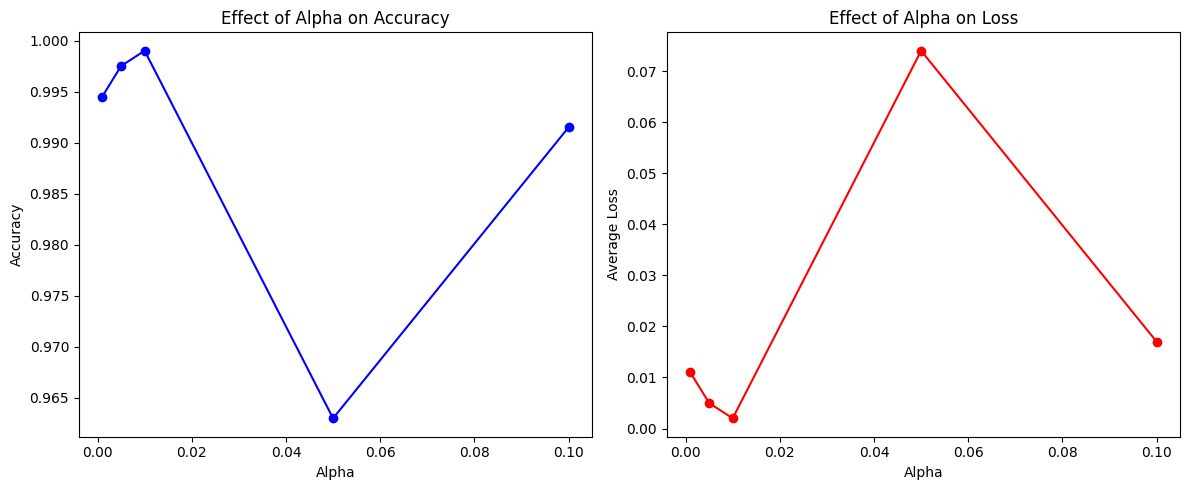

Building vocabulary...
Vocabulary size: 50662

Training model...
Iter: 0 Avg Hinge Loss: 0.31051253946656426
Iter: 1 Avg Hinge Loss: 0.06372345463846962
Iter: 2 Avg Hinge Loss: 0.04678830137587807
Iter: 3 Avg Hinge Loss: 0.02258918192132636
Iter: 4 Avg Hinge Loss: 0.017969510756423376
Iter: 5 Avg Hinge Loss: 0.05269231520827585
Iter: 6 Avg Hinge Loss: 0.03223906433540275
Iter: 7 Avg Hinge Loss: 0.1297283198782597
Iter: 8 Avg Hinge Loss: 0.006900143083193663
Iter: 9 Avg Hinge Loss: 0.004092660818286853
Training completed.

Building vocabulary...
Vocabulary size: 50662

Training model...
Iter: 0 Avg Hinge Loss: 0.30915178695273815
Iter: 1 Avg Hinge Loss: 0.06966056717536147
Iter: 2 Avg Hinge Loss: 0.08649345761118271
Iter: 3 Avg Hinge Loss: 0.053392795933899166


In [ ]:
import matplotlib.pyplot as plt

# Define ranges for alpha and regularization strength
alphas = [0.001, 0.005, 0.01, 0.05, 0.1]
regularization_strengths = [0.01, 0.05, 0.1, 0.5, 1.0]

# Store metrics
accuracy_results = []
loss_results = []

# Iterate through alpha values and plot results
def evaluate_alphas(spam, ham, alphas, regularization_strength=0.05):
    global accuracy_results, loss_results
    accuracy_results = []
    loss_results = []

    for alpha in alphas:
        model = SVM(spam[:-1000], ham[:-1000], public_key, alpha=alpha, regularization_strength=regularization_strength)
        accuracy, avg_loss = model.evaluate(spam[-1000:], ham[-1000:])
        
        accuracy_results.append(accuracy)
        loss_results.append(avg_loss)
    
    plt.figure(figsize=(12, 5))

    # Plot Accuracy vs Alpha
    plt.subplot(1, 2, 1)
    plt.plot(alphas, accuracy_results, marker='o', color='b')
    plt.xlabel("Alpha")
    plt.ylabel("Accuracy")
    plt.title("Effect of Alpha on Accuracy")
    
    # Plot Loss vs Alpha
    plt.subplot(1, 2, 2)
    plt.plot(alphas, loss_results, marker='o', color='r')
    plt.xlabel("Alpha")
    plt.ylabel("Average Loss")
    plt.title("Effect of Alpha on Loss")
    plt.tight_layout()
    plt.show()

# Iterate through regularization strengths and plot results
def evaluate_regularization_strengths(spam, ham, regularization_strengths, alpha=0.005):
    global accuracy_results, loss_results
    accuracy_results = []
    loss_results = []

    for reg_strength in regularization_strengths:
        model = SVM(spam[:-1000], ham[:-1000], public_key, alpha=alpha, regularization_strength=reg_strength)
        accuracy, avg_loss = model.evaluate(spam[-1000:], ham[-1000:])
        
        accuracy_results.append(accuracy)
        loss_results.append(avg_loss)
    
    plt.figure(figsize=(12, 5))

    # Plot Accuracy vs Regularization Strength
    plt.subplot(1, 2, 1)
    plt.plot(regularization_strengths, accuracy_results, marker='o', color='b')
    plt.xlabel("Regularization Strength")
    plt.ylabel("Accuracy")
    plt.title("Effect of Regularization Strength on Accuracy")

    # Plot Loss vs Regularization Strength
    plt.subplot(1, 2, 2)
    plt.plot(regularization_strengths, loss_results, marker='o', color='r')
    plt.xlabel("Regularization Strength")
    plt.ylabel("Average Loss")
    plt.title("Effect of Regularization Strength on Loss")

    plt.tight_layout()
    plt.show()

# Call these functions to plot the graphs
evaluate_alphas(spam, ham, alphas)
evaluate_regularization_strengths(spam, ham, regularization_strengths)
